In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:

customer_usage = pd.read_csv('/workspaces/task_mobile/src/insights/CSV_files/Customer_Usage_Last_12_Months.csv')
mobile_plans = pd.read_csv('/workspaces/task_mobile/src/insights/CSV_files/Mobile_Plans_Test_Data.csv')

customer_usage['Month'] = pd.to_datetime(customer_usage['Month'])

In [3]:
def calculate_usage_statistics(usage_data, statistic='mean'):
    """Calculate usage statistics for each customer."""
    if statistic not in ['max', 'min', 'median', 'mean']:
        raise ValueError("Invalid statistic. Choose from: max, min, median, mean")
    
    stats = usage_data.groupby('CustomerID').agg({
        'Monthly Data Usage (GB)': statistic,
        'Monthly Minutes Usage': statistic,
        'Monthly SMS Usage': statistic
    }).reset_index()
    
    return stats

def calculate_plan_cost(usage, plan):
    """Calculate total cost for a given usage under a specific plan."""
    total_cost = plan['Monthly Cost ($)']
    
    overcharges = {
        'Data': max(0, np.ceil(usage['Monthly Data Usage (GB)'] - plan['Data Limit (GB)'])) * plan['Data Overcharge ($/GB)'],
        'Minutes': max(0, usage['Monthly Minutes Usage'] - plan['Minutes Limit']) * plan['Minutes Overcharge ($/min)'],
        'SMS': max(0, usage['Monthly SMS Usage'] - plan['SMS Limit']) * plan['SMS Overcharge ($/SMS)']
    }
    
    return total_cost + sum(overcharges.values()), overcharges

def find_best_plans(usage_stats, plans, statistic):
    """Find the best plan for each customer with detailed cost breakdown."""
    best_plans = []
    
    for _, customer_usage in usage_stats.iterrows():
        customer_id = customer_usage['CustomerID']
        min_cost = float('inf')
        best_plan_details = None
        
        for _, plan in plans.iterrows():
            total_cost, overcharges = calculate_plan_cost(customer_usage, plan)
            
            if total_cost < min_cost:
                min_cost = total_cost
                best_plan_details = {
                    'CustomerID': customer_id,
                    'Best Plan': plan['Plan Name'],
                    'Provider': plan['Provider'],
                    'Base Cost': plan['Monthly Cost ($)'],
                    'Total Cost': round(total_cost, 2),
                    'Data Overcharge': round(overcharges['Data'], 2),
                    'Minutes Overcharge': round(overcharges['Minutes'], 2),
                    'SMS Overcharge': round(overcharges['SMS'], 2)
                }
                
        best_plans.append(best_plan_details)
    
    return pd.DataFrame(best_plans)

In [4]:
statistics = ['max', 'min', 'median', 'mean']
all_results = {}

for stat in statistics:
    usage_stats = calculate_usage_statistics(customer_usage, stat)
    best_plans = find_best_plans(usage_stats, mobile_plans, stat)
    all_results[stat] = best_plans

def create_comparison_table():
    comparisons = []
    
    for customer_id in customer_usage['CustomerID'].unique():
        customer_comparison = {'CustomerID': customer_id}
        
        for stat in statistics:
            customer_result = all_results[stat][all_results[stat]['CustomerID'] == customer_id].iloc[0]
            customer_comparison.update({
                f'Plan ({stat.capitalize()})': customer_result['Best Plan'],
                f'Provider ({stat.capitalize()})': customer_result['Provider'],
                f'Cost ({stat.capitalize()})': customer_result['Total Cost']
            })
            
        comparisons.append(customer_comparison)
    
    return pd.DataFrame(comparisons)

comparison_df = create_comparison_table()
styled_df = comparison_df.style.background_gradient(subset=[col for col in comparison_df.columns if 'Cost' in col], cmap='YlOrRd')\
    .format({col: '${:.2f}' for col in comparison_df.columns if 'Cost' in col})


In [5]:
styled_df = comparison_df.style.background_gradient(
    subset=[col for col in comparison_df.columns if 'Cost' in col], 
    cmap='YlOrRd'
).format({col: '${:.2f}' for col in comparison_df.columns if 'Cost' in col})

styled_df

,CustomerID,Plan (Max),Provider (Max),Cost (Max),Plan (Min),Provider (Min),Cost (Min),Plan (Median),Provider (Median),Cost (Median),Plan (Mean),Provider (Mean),Cost (Mean)
0,C001,Standard,ProviderB,$30.00,Economy,ProviderC,$15.00,Basic,ProviderA,$25.00,Basic,ProviderA,$25.00
1,C002,Unlimited,ProviderB,$81.00,Standard,ProviderB,$30.00,Pro,ProviderC,$40.80,Pro,ProviderC,$40.00
2,C003,Basic,ProviderA,$27.40,Economy,ProviderC,$15.00,Economy,ProviderC,$15.00,Economy,ProviderC,$15.00
3,C004,Unlimited,ProviderB,$78.90,Premium,ProviderA,$54.45,Premium,ProviderA,$63.25,Unlimited,ProviderB,$70.00
4,C005,Standard,ProviderB,$36.00,Basic,ProviderA,$20.00,Standard,ProviderB,$30.00,Standard,ProviderB,$30.00


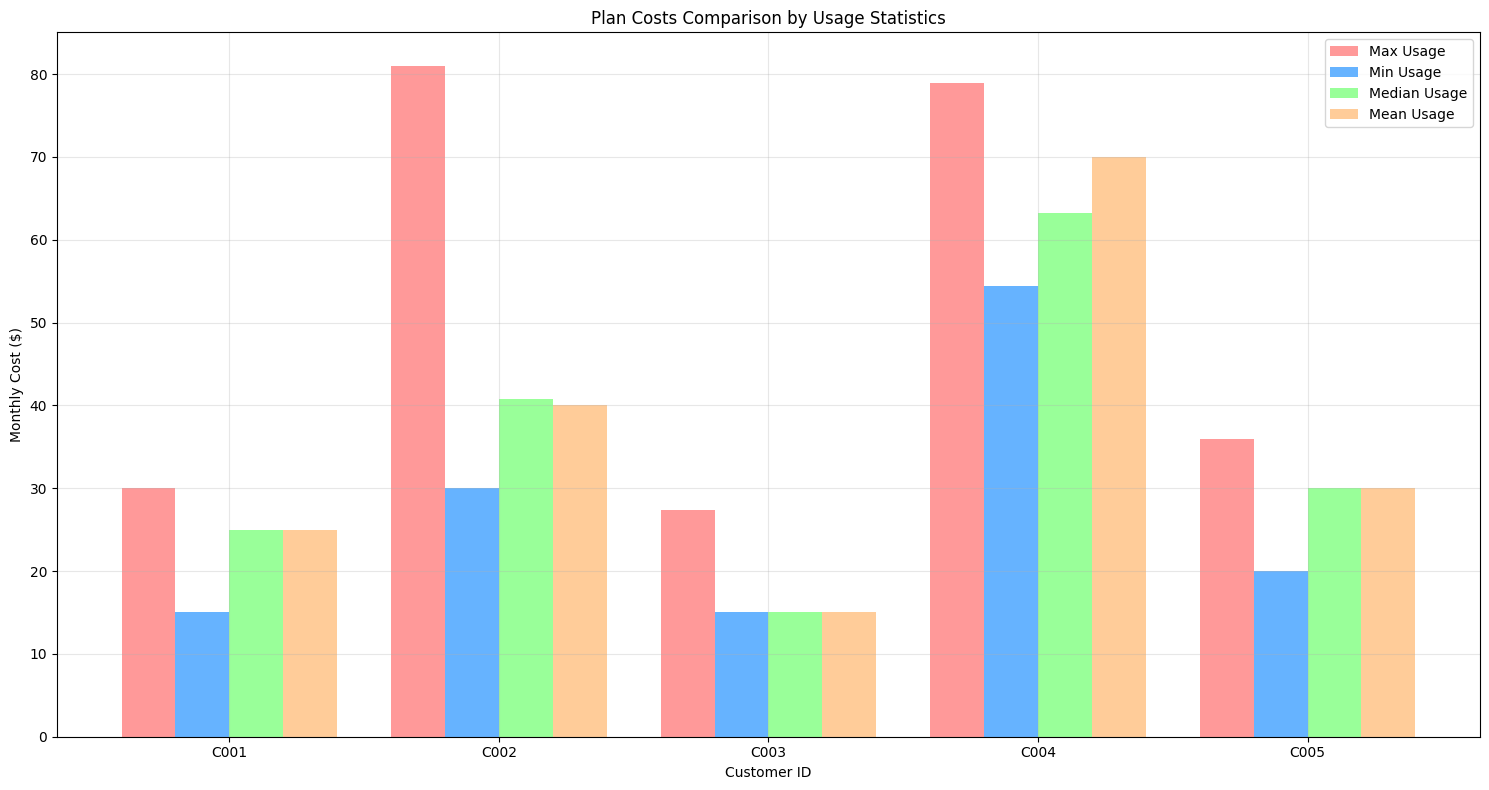

In [6]:
plt.figure(figsize=(15, 8))
customer_ids = comparison_df['CustomerID'].unique()
x = np.arange(len(customer_ids))
width = 0.2

colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
for i, stat in enumerate(statistics):
    costs = comparison_df[f'Cost ({stat.capitalize()})']
    plt.bar(x + i*width, costs, width, label=f'{stat.capitalize()} Usage', color=colors[i])

plt.xlabel('Customer ID')
plt.ylabel('Monthly Cost ($)')
plt.title('Plan Costs Comparison by Usage Statistics')
plt.xticks(x + width*1.5, customer_ids)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()